# Análisis no supervisado de resúmenes de artículos


## Algunas referencias
## The Illustrated Word2Vec - Jay Alamar ##
https://jalammar.github.io/illustrated-word2vec/

## Word2Vec explained: ##
https://towardsdatascience.com/word2vec-explained-49c52b4ccb71
## How to Cluster Documents Using Word2Vec and K-means - Dylan Castillo ##
https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
## Vectoring Words (Word Embeddings) - Computerphile ##
https://www.youtube.com/watch?v=gQddtTdmG_8
## Segmentación utilizando k-kmeans en python ##
https://machinelearningparatodos.com/segmentacion-utilizando-k-means-en-python/
## Pubmed Parser ##
https://github.com/titipata/pubmed_parser

---

**Análisis no supervisado de texto**


Uno de los temas recurrentes en el análisis de textos es tratar de organizar o clasificar documentos de acuerdo a su contenido. Por ejemplo: en el caso de noticias estaríamos interesados en organizarlas de acuerdo a tendencias u opiniones generadas en redes sociales; en el caso de libros estaríamos interesados en organizarlos de acuerdo al estilo de escritura del autor o su contenido; o en el caso de películas estaríamos interesados en agruparlas de acuerdo a su sinópsis. Todos estos casos de análisis de texto usualmente carecen de etiquetas para poderlos clasificar. Este tipo de problemas entran en la categoría de "análisis no supervisado de texto", por tanto no es posible generar un modelo de clasificación basado en técnicas para textos etiquetados. En este caso se aplican otro tipo de modelos para agrupar los textos o para tratar de generar categorías de clasificación (temas), no basada en etiquetas, sino en el mismo contenido de los documentos (agrupamientos). En el presente notebook intentaremos agrupar resúmenes (abstracts) de artículos de acuerdo a sus contenidos. Para ello utilizaremos métodos de representación o transformación de texto en vectores (embeddings), para luego utilizar métricas que nos permitan determinar qué tan cercano está un texto del otro y con base en ello generar grupos de resúmenes. Idealmente estos grupos de resúmenes deberían tener "temas" comunes que sirvan como puntos de partida para la revisión de literatura que ustedes harán como parte de la investigación relacionada con sus trabajos de grado.

Para agrupar los resúmenes utilizaremos la técnica de agrupamiento K-Means, muy utilizada en análisis de datos.



## Librerías

<font color="red"><b>  Pregunta</b>:</font>
¿qué es y para qué sirve  pubmed_parser?

In [1]:
# Instalación de pubmed_parser
!pip install pubmed_parser

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 25.3 MB/s eta 0:00:00
  Created wheel for pubmed_parser: filename=pubmed_parser-0.3.1-py3-none-any.whl size=18495 sha256=fbcdc1057c50a01260e2723af09b33b6cfb3fdaac39d22d56ab3a93b1a45b579
  Stored in directory: /root/.cache/pip/wheels/78/d4/ed/dae73ff36a1adbc2d306265ff1b262692e0a84b78f56597d8c
Successfully built pubmed_parser


<font color="red"><b>  Pregunta</b>:</font>

Consultar por las librerías:
* nltk
* re
* json

In [2]:
import pubmed_parser as pp
import numpy as np
import pandas as pd
import json, nltk, re
import matplotlib.pyplot as plt
#plt.style.use("ggplot")

In [ ]:
#np.random.seed(0)

## Carga y manipulación de datos
###Obtener el XML###
Realice una búsqueda en pubmed con la ecuación de su elección. Descargue sólo los identificadores de pubmed y guardelos en un archivo. Luego diríjase a la página pubmed XML:
https://pubmed2xl.com/xml/, pegue los identificadores y luego descargue el archivo xml.
###Subir el archivo a colab ###
En la parte izquierda de la ventana de colab encontrará un ícono que al momento de pasar el mouse sobre él, mostrará la palabra 'files' o 'archivos'. Haga click ahí, y luego arrastre el xml a ese espacio.


In [3]:
archivo = "/content/SINTESISVERDE.xml"

In [4]:
parsed_articles = pp.parse_medline_xml(archivo)

In [5]:
type(parsed_articles)

list

In [6]:
len(parsed_articles)

1299

In [7]:
type(parsed_articles[0])

dict

In [8]:
parsed_articles[0].keys()

dict_keys(['title', 'issue', 'pages', 'abstract', 'journal', 'authors', 'pubdate', 'pmid', 'mesh_terms', 'publication_types', 'chemical_list', 'keywords', 'doi', 'references', 'delete', 'affiliations', 'pmc', 'other_id', 'medline_ta', 'nlm_unique_id', 'issn_linking', 'country'])

Creamos un DataFrame

In [9]:
articlesPD = pd.DataFrame.from_dict(parsed_articles)

In [10]:
type(articlesPD)

pandas.core.frame.DataFrame

In [11]:
articlesPD.head(5)

,title,issue,pages,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,...,doi,references,delete,affiliations,pmc,other_id,medline_ta,nlm_unique_id,issn_linking,country
0,Phyto-Capped Ag Nanoparticles: Green Synthesis...,12(3),,"Using a simple approach, silver nanoparticles ...","Nanomaterials (Basel, Switzerland)",Kordy|Mohamed G M|MGM|0000-0002-5799-4996;Abde...,2022,35159718,,D016428:Journal Article,...,10.3390/nano12030373,32120184;23317879;31610431;34578695;26664112;2...,False,"Biochemistry Department, Faculty of Science, B...",,,Nanomaterials (Basel),101610216,2079-4991,Switzerland
1,Green Synthesis of Silver Nanoparticles (Ag-NP...,16(1),,The synthesis of nanoparticles (NPs) using the...,"Materials (Basel, Switzerland)",Khan|Jahanzeb|J|0000-0003-3738-7053;Naseem|Irs...,2022,36614468,,D016428:Journal Article,...,10.3390/ma16010129,33106647;23984878;31674087;22143077;17112619;2...,False,"Department of Chemistry, Mirpur University of ...",,,Materials (Basel),101555929,1996-1944,Switzerland
2,Green synthesis of Ag nanoparticles using elm ...,213(),1078-1087,The green synthesis of silver nanoparticles (A...,International journal of biological macromolec...,He|Mengmeng|M|;Han|Zengsheng|Z|;Liang|Ying|Y|;...,2022,35691426,D000900:Anti-Bacterial Agents; D002384:Catalys...,D016428:Journal Article,...,,,False,"Key Laboratory of Applied Chemistry, Nano-biot...",,,Int J Biol Macromol,7909578,0141-8130,Netherlands
3,Recent Developments in the Plant-Mediated Gree...,19(12),2436-2479,"Among different metallic nanoparticles, sliver...","Chemical record (New York, N.Y.)",Nasrollahzadeh|Mahmoud|M|;Mahmoudi-Gom Yek|Sam...,2019,31021524,D000900:Anti-Bacterial Agents; D001562:Benzimi...,D016428:Journal Article; D016454:Review,...,10.1002/tcr.201800202,,False,"Department of Chemistry, Faculty of Science, U...",,,Chem Rec,101085550,1528-0691,United States
4,Progress in Laser Ablation and Biological Synt...,23(23),,Because of their small size and large specific...,International journal of molecular sciences,Jiang|Zhiwen|Z|;Li|Liwei|L|;Huang|Hao|H|;He|We...,2022,36498986,D053768:Metal Nanoparticles; D012834:Silver; D...,D016428:Journal Article; D016454:Review,...,10.3390/ijms232314658,31892180;35564233;35564200;16791330;21109866;2...,False,Henan Key Lab of Intelligent Manufacturing of ...,,,Int J Mol Sci,101092791,1422-0067,Switzerland


In [12]:
articlesPD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              1299 non-null   object
 1   issue              1299 non-null   object
 2   pages              1299 non-null   object
 3   abstract           1299 non-null   object
 4   journal            1299 non-null   object
 5   authors            1299 non-null   object
 6   pubdate            1299 non-null   object
 7   pmid               1299 non-null   object
 8   mesh_terms         1299 non-null   object
 9   publication_types  1299 non-null   object
 10  chemical_list      1299 non-null   object
 11  keywords           1299 non-null   object
 12  doi                1299 non-null   object
 13  references         1299 non-null   object
 14  delete             1299 non-null   bool  
 15  affiliations       1299 non-null   object
 16  pmc                1299 non-null   object


Generar un csv con la los datos

In [13]:
export_csv = articlesPD.to_csv ('export_dataframe.csv', index = None, header = True)

In [14]:
# Verificamos la longitud del dataframe
len(articlesPD)

1299

Filtro: Se hace un DataFrame corto con DOI, título y resumen

In [15]:
smalldf = articlesPD[["pmid", "title", "abstract"]].copy()

In [16]:
smalldf.head(5)

,pmid,title,abstract
0,35159718,Phyto-Capped Ag Nanoparticles: Green Synthesis...,"Using a simple approach, silver nanoparticles ..."
1,36614468,Green Synthesis of Silver Nanoparticles (Ag-NP...,The synthesis of nanoparticles (NPs) using the...
2,35691426,Green synthesis of Ag nanoparticles using elm ...,The green synthesis of silver nanoparticles (A...
3,31021524,Recent Developments in the Plant-Mediated Gree...,"Among different metallic nanoparticles, sliver..."
4,36498986,Progress in Laser Ablation and Biological Synt...,Because of their small size and large specific...


In [17]:
len(smalldf)

1299

Verifico si hay datos nulos

In [19]:
smalldf.isnull().sum()

pmid        0
title       0
abstract    0
dtype: int64

In [20]:
smalldf.dropna(axis = 0, inplace = True)

<font color="red"><b>  Pregunta</b>:</font>
¿qué es un corpus? En el contexto de PLN.

Se seleccionan los abstracts para construir el corpus como una lista de textos

In [21]:
corpus = smalldf.abstract.tolist()

In [23]:
type(corpus)

list

In [24]:
type(corpus[0])

str

In [25]:
corpus[0]

"Using a simple approach, silver nanoparticles (Ag NPs) were synthesized from green coffee bean extract. The optical color change from yellowish to reddish-brown of the green-produced Ag NPs was initially observed, which was confirmed by the UV-Visible spectrophotometer's surface plasmonic resonance (SPR) bands at 329 and 425 nm. The functional groups of green coffee-capped Ag NPs (GC-capped Ag NPs) were studied using a Fourier transform infrared spectrometer, revealing that Ag NPs had been capped by phytochemicals, resulting in excellent stability, and preventing nanoparticle aggregation. The presence of elemental silver is confirmed by energy dispersive X-ray analysis. In addition to the measurement of the zeta potential of the prepared GC-capped Ag NPs, the size distribution is evaluated by the dynamic light scattering. Depending on the nano-morphological study, the particle diameter of Ag NPs is 8.6 ± 3.5 nm, while the particle size of GC-capped Ag NPs is 29.9 ± 4.3 nm, implying th

Ahora genero una lista con los DOI

In [26]:
pmid = smalldf.pmid.tolist()

In [27]:
type(pmid)

list

In [28]:
pmid[0]

'35159718'

Una lista con los títulos

In [29]:
titles = smalldf.title.tolist()

In [30]:
type(titles)

list

In [31]:
titles[0]

'Phyto-Capped Ag Nanoparticles: Green Synthesis, Characterization, and Catalytic and Antioxidant Activities.'

In [32]:
type(titles[0])

str

In [33]:
len(titles)

1299

<font color="red"><b>  Pregunta</b>:</font>
¿qué son y para qué sirven las stopwords?

In [34]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
type(nltk.corpus.stopwords.words("english"))

list

In [36]:
len(nltk.corpus.stopwords.words("english"))

179

El archivo tiene 179 stopwords.

In [37]:
print(nltk.corpus.stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Preprocesamiento

Como parte del preprocesamiento del texto, pasaremos los resúmenes a minúsculas, se removerán los signos de puntuación, se removerán las stopwords y los caracteres especiales.

<font color="red"><b>  Pregunta</b>:</font>
* ¿qué es tokenizar? En el contexto de NLP.
* ¿qué significa re.I|re.A?
*¿qué hace .lower()?

Se construye una función para el procesamiento de datos.

In [38]:
def preprocessing(doc):
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    tokens = wpt.tokenize(doc)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

Verifico el resultado del procesamiento del primer resumen, está guardado en corpus[0]

In [39]:
corpus[0]

"Using a simple approach, silver nanoparticles (Ag NPs) were synthesized from green coffee bean extract. The optical color change from yellowish to reddish-brown of the green-produced Ag NPs was initially observed, which was confirmed by the UV-Visible spectrophotometer's surface plasmonic resonance (SPR) bands at 329 and 425 nm. The functional groups of green coffee-capped Ag NPs (GC-capped Ag NPs) were studied using a Fourier transform infrared spectrometer, revealing that Ag NPs had been capped by phytochemicals, resulting in excellent stability, and preventing nanoparticle aggregation. The presence of elemental silver is confirmed by energy dispersive X-ray analysis. In addition to the measurement of the zeta potential of the prepared GC-capped Ag NPs, the size distribution is evaluated by the dynamic light scattering. Depending on the nano-morphological study, the particle diameter of Ag NPs is 8.6 ± 3.5 nm, while the particle size of GC-capped Ag NPs is 29.9 ± 4.3 nm, implying th

In [40]:
preprocessing(corpus[0])

'using simple approach silver nanoparticles ag nps synthesized green coffee bean extract optical color change yellowish reddish brown green produced ag nps initially observed confirmed uv visible spectrophotometer surface plasmonic resonance spr bands nm functional groups green coffee capped ag nps gc capped ag nps studied using fourier transform infrared spectrometer revealing ag nps capped phytochemicals resulting excellent stability preventing nanoparticle aggregation presence elemental silver confirmed energy dispersive x ray analysis addition measurement zeta potential prepared gc capped ag nps size distribution evaluated dynamic light scattering depending nano morphological study particle diameter ag nps nm particle size gc capped ag nps nm implying presence well dispersed nanospheres average capsulation layer thickness nm phyto capped ag nps found crystalline face centered cubic fcc lattice structure ag crystallite size nm according xrd crystallographic analysis catalytic perfor

Aplico el procesamiento sobre todos los resumenes

In [41]:
norm_corpus = list(map(preprocessing, corpus))

Examino los tres primeros resumenes procesados

In [42]:
norm_corpus[:2]

['using simple approach silver nanoparticles ag nps synthesized green coffee bean extract optical color change yellowish reddish brown green produced ag nps initially observed confirmed uv visible spectrophotometer surface plasmonic resonance spr bands nm functional groups green coffee capped ag nps gc capped ag nps studied using fourier transform infrared spectrometer revealing ag nps capped phytochemicals resulting excellent stability preventing nanoparticle aggregation presence elemental silver confirmed energy dispersive x ray analysis addition measurement zeta potential prepared gc capped ag nps size distribution evaluated dynamic light scattering depending nano morphological study particle diameter ag nps nm particle size gc capped ag nps nm implying presence well dispersed nanospheres average capsulation layer thickness nm phyto capped ag nps found crystalline face centered cubic fcc lattice structure ag crystallite size nm according xrd crystallographic analysis catalytic perfo

## Representación

Para representar cada documento utilizaremos **Word2Vec**,  este modelo se entrenará utilizando todo el corpus (resumenes) de los artículos.

El algoritmo **Word2vec** utiliza un modelo de red neuronal para aprender asociaciones de palabras a partir de un gran corpus de texto.

<font color="red"><b>  Pregunta</b>:</font>
* ¿qué es y para qué sirve **Word2Vec**?
* ¿explique el uso de los parámetros de la función **Word2Vec**?

In [43]:
from gensim.models import word2vec
vector_size = 50
window_context = 3
min_word_count = 1
sample = 1e-3
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size = vector_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, sg = 0)

In [44]:
type(tokenized_corpus)

list

In [45]:
len(tokenized_corpus)

1299

In [46]:
print(tokenized_corpus)

[['using', 'simple', 'approach', 'silver', 'nanoparticles', 'ag', 'nps', 'synthesized', 'green', 'coffee', 'bean', 'extract', 'optical', 'color', 'change', 'yellowish', 'reddish', 'brown', 'green', 'produced', 'ag', 'nps', 'initially', 'observed', 'confirmed', 'uv', 'visible', 'spectrophotometer', 'surface', 'plasmonic', 'resonance', 'spr', 'bands', 'nm', 'functional', 'groups', 'green', 'coffee', 'capped', 'ag', 'nps', 'gc', 'capped', 'ag', 'nps', 'studied', 'using', 'fourier', 'transform', 'infrared', 'spectrometer', 'revealing', 'ag', 'nps', 'capped', 'phytochemicals', 'resulting', 'excellent', 'stability', 'preventing', 'nanoparticle', 'aggregation', 'presence', 'elemental', 'silver', 'confirmed', 'energy', 'dispersive', 'x', 'ray', 'analysis', 'addition', 'measurement', 'zeta', 'potential', 'prepared', 'gc', 'capped', 'ag', 'nps', 'size', 'distribution', 'evaluated', 'dynamic', 'light', 'scattering', 'depending', 'nano', 'morphological', 'study', 'particle', 'diameter', 'ag', 'nps

In [47]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

Una vez entrenado el modelo, podemos preguntarle sobre similitud de términos

Una pregunta típica es ¿cuáles son los términos más parecidos al térmno "nanoparticles"

In [48]:
w2v_model.wv.most_similar("nanoparticles")

[('gold', 0.9784165620803833),
 ('metallic', 0.9628950953483582),
 ('prepared', 0.9595931172370911),
 ('stable', 0.9586374759674072),
 ('silver', 0.9540247321128845),
 ('colloidal', 0.9538258910179138),
 ('nanosized', 0.9516189694404602),
 ('nanoparticle', 0.9514701962471008),
 ('agnps', 0.9451602697372437),
 ('synthesized', 0.9417204856872559)]

¿Qué tan parecidos son los términos 'nanoparticles', 'silver'?

In [49]:
w2v_model.wv.similarity('nanoparticles', 'silver')

0.95402473

* ¿Cuáles son los términos más parecidos a la palabra 'silver'?

* ¿qué hace la función most_similar()?

In [50]:
w2v_model.wv.most_similar('silver')

[('gold', 0.9799017310142517),
 ('metallic', 0.9672090411186218),
 ('nanosized', 0.9604610800743103),
 ('prepared', 0.9600151181221008),
 ('metal', 0.9550652503967285),
 ('stable', 0.954622745513916),
 ('nanoparticles', 0.9540246725082397),
 ('biosynthesis', 0.9473826289176941),
 ('synthesized', 0.9473376274108887),
 ('bimetallic', 0.945538341999054)]

Es posible indicar que algunas palabas incrementan (positive) a la similaridad mientras que otras la reducen (negative).

In [51]:
w2v_model.wv.most_similar_cosmul(positive = ['nanoparticles', 'silver'], negative = ['gold'])

[('metallic', 0.9748346209526062),
 ('nanosized', 0.9734978079795837),
 ('stable', 0.9710567593574524),
 ('prepared', 0.9694427251815796),
 ('colloidal', 0.966806948184967),
 ('nanoparticle', 0.9640533328056335),
 ('synthesized', 0.9634301066398621),
 ('agnps', 0.9626283645629883),
 ('biosynthesis', 0.9625011086463928),
 ('nano', 0.959868848323822)]

Se construye la representación de los documentos como el promedio de la representación de cada una de sus palabras.

Para el modelo anterior hemos vectorizado las palabras que están dentro del corpus en sus respectivos contextos.

Pero otra de las motivaciones es agrupar los abstracts de los artículos
Para eso se hace necesario vectorizar cada documento, es decir cada abstract.

Cada documento quedará representado por un vector de tamaño 50

In [52]:
def w2v_repr(corpus):
    w2v_representations = []
    tokenized_corpus = [wpt.tokenize(document) for document in corpus]
    for sentence in tokenized_corpus:
        try:
            w2v_representations.append(w2v_model.wv[sentence].mean(axis=0))
        except:
            w2v_representations.append(np.zeros(shape=(vector_size,)))
    return np.array(w2v_representations)
vectorized_docs = w2v_repr(norm_corpus)
len(vectorized_docs), len(vectorized_docs[0])

(1299, 50)

In [53]:
vectorized_docs[0]

array([ 1.53870016e-01,  2.01188117e-01,  4.78943363e-02,  9.23656449e-02,
       -4.27499652e-01, -9.56077516e-01,  7.59032667e-01,  9.58547473e-01,
       -1.16459966e+00, -5.95556140e-01,  7.47325793e-02, -8.06479990e-01,
        2.89014339e-01,  7.05146551e-01, -4.71313477e-01,  2.36691475e-01,
        8.36862803e-01,  5.02139807e-01, -8.59239876e-01, -4.97331023e-01,
        6.95851296e-02,  4.38038558e-01,  8.60858142e-01, -1.13538338e-03,
        6.39957011e-01,  3.03512096e-01, -2.23031938e-01,  4.19311225e-01,
       -5.33275247e-01,  5.45510501e-02, -4.44661500e-03, -1.31156802e-01,
        1.03489399e-01, -7.51002459e-03, -7.59806931e-01,  4.19003248e-01,
        6.75157607e-01, -9.45125669e-02,  1.99241340e-01, -1.13585204e-01,
        6.83710754e-01,  6.78335652e-02, -8.66791680e-02,  2.69110978e-01,
        1.57666767e+00,  2.37785324e-01, -1.61645308e-01, -3.05025309e-01,
        4.64243263e-01,  2.75558174e-01])

In [54]:
vectorized_docs#.shape

array([[ 0.15387002,  0.20118812,  0.04789434, ..., -0.30502531,
         0.46424326,  0.27555817],
       [ 0.14536317,  0.26280424,  0.10972924, ..., -0.30966851,
         0.49674961,  0.22656628],
       [ 0.01719898,  0.20017147,  0.06491712, ..., -0.29553834,
         0.42179129,  0.17796071],
       ...,
       [-0.05524288,  0.17466415,  0.08248135, ..., -0.29902062,
         0.49152318,  0.21256599],
       [ 0.07179929,  0.1014921 ,  0.00745171, ..., -0.26771414,
         0.22779751,  0.09462949],
       [ 0.00489702,  0.18939151,  0.09874938, ..., -0.34535861,
         0.33972377,  0.12935176]])

# WordCloud

Podemos visualizar una nube de palabras con los términos más relevantes de cada cluster con el fin de interpretar sus relaciones semánticas.

In [55]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

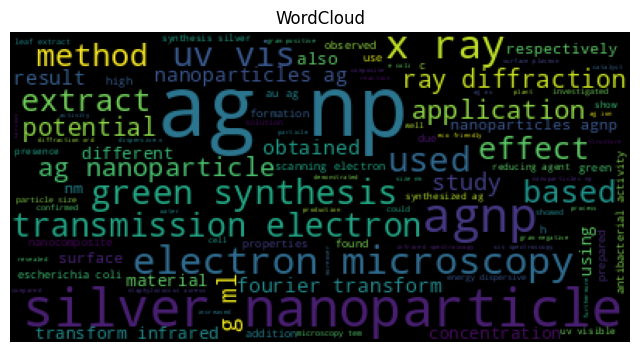

In [56]:
plt.figure(figsize = (8, 5))
all_words = " ".join(norm_corpus)
im = WordCloud(stopwords = stopwords.words("english")).generate(all_words)
plt.imshow(im)
plt.axis("off")
plt.title("WordCloud")
plt.show()